# Hexagonal Grid Topology

In this notebook, we illustrate how to build a multicell topology for
system-level simulation purposes and compute the SINR distribution across the users.

More specifically, we show how to:
- Place base stations on a hexagonal grid
  under the wraparound principle to reduce boundary effects;
- Ensure that the topology generation is 3GPP compliant;
- Drop users uniformly in each sector;
- Compute post-equalization signal-to-interference-plus-noise ratio
  (SINR) for a given set of channel matrices.


## Imports
We start by importing Sionna and the relevant external libraries:

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Using GPU 0



In [4]:
# Additional external libraries
import numpy as np
import matplotlib.pyplot as plt

# Sionna components
from sionna.phy.utils import flatten_dims, sample_bernoulli
from sionna.phy.utils import log2, dbm_to_watt
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.channel import GenerateOFDMChannel
from sionna.phy.ofdm import ResourceGrid, RZFPrecodedChannel, EyePrecodedChannel, LMMSEPostEqualizationSINR
from sionna.phy.channel.tr38901 import UMi, UMa, RMa, PanelArray
from sionna.phy.mimo import StreamManagement
from sionna.sys import HexGrid, gen_hexgrid_topology
from sionna.sys.utils import spread_across_subcarriers

# Internal computational precision
sionna.phy.config.precision = 'single'  # 'single' or 'double'

# Set random seed for reproducibility
sionna.phy.config.seed = 45

## Generate a multicell topology

In system-level simulations with
3GPP channel modeling, it is customary to place cells uniformly in space
on a so-called [*spiral hexagonal grid*](https://nvlabs.github.io/sionna/sys/api/topology.html#sionna.sys.topology.HexGrid).

The main parameters defining the hexagonal grid are:
- Inter-site distance, determining the distance between any two adjacent
  hexagonal cell centers;
- Number of rings of the grid, typically 1 or 2 (corresponding to 7 and 19
  hexagons, respectively).

Cell center locations (X,Y,Z) [m]:
[[   0.        0.       10.    ]
 [-433.0127  250.       10.    ]
 [   0.      500.       10.    ]
 [ 433.0127  250.       10.    ]
 [ 433.0127 -250.       10.    ]
 [   0.     -500.       10.    ]
 [-433.0127 -250.       10.    ]]


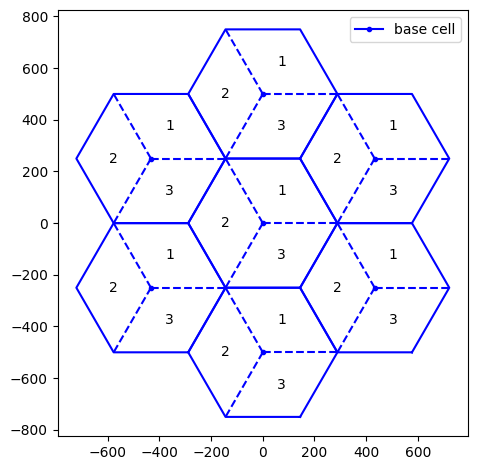

In [5]:
# Inter-site distance, i.e.,
# distance between the centers of two adjacent hexagons
isd = 500  # [m]

# Number of rings (typically, 1 or 2)
num_rings = 1

# Cell height
cell_height = 10  # [m]

grid = HexGrid(isd=isd,
               num_rings=num_rings,
               cell_height=cell_height)

print(f'Cell center locations (X,Y,Z) [m]:\n{grid.cell_loc.numpy()}')
fig = grid.show(show_sectors=True)

Each hexagonal cell is divided into three sectors, as indicated in the figure.  
When we will place base stations, each of them will serve a specific sector.

## Drop users

After defining the hexagonal grid, we distribute users uniformly at random within
each sector.

We can control the number of users per sector, their minimum and maximum
distance from the nearest cell center, and their height.

ut_loc.shape = TensorShape([1, 7, 3, 5, 3])
mirrors_per_ut_loc.shape = TensorShape([1, 7, 3, 5, 7, 3])


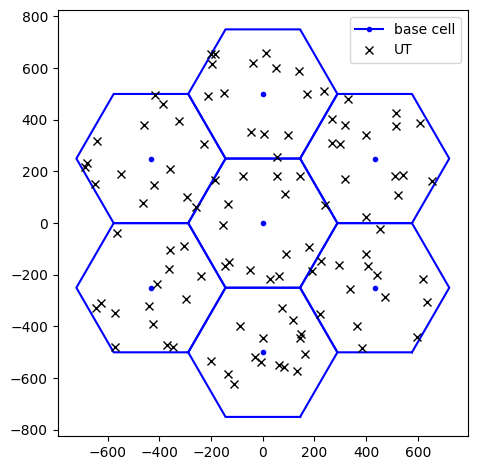

In [6]:
batch_size = 1

# N. users per sector
num_ut_per_sector = 5

# Min/max distance between a user and the nearest cell center
min_bs_ut_dist = 0
max_bs_ut_dist = None  # If None, users can be anywhere in the sector

# Min/max user height
min_ut_height = 1.5
max_ut_height = 2

# Drop users uniformly within each sector
ut_loc, mirrors_per_ut_loc, wrap_dist_tf = \
    grid(batch_size,
         num_ut_per_sector,
         min_bs_ut_dist,
         max_bs_ut_dist=max_bs_ut_dist,
         min_ut_height=min_ut_height,
         max_ut_height=max_ut_height)

print(f'{ut_loc.shape = }')
# [batch_size, num_cells, num_sectors=3, num_ut_per_sector, 3]

print(f'{mirrors_per_ut_loc.shape = }')
# [batch_size, num_cells, num_sectors=3, num_ut_per_sector, num_cells, 3]

ut_loc = flatten_dims(ut_loc, num_dims=3, axis=1)

fig = grid.show()
ax = fig.get_axes()[0]
ax.plot(ut_loc[0, :, 0], ut_loc[0, :, 1], 'xk', label='UT')
ax.legend()
plt.show()

### Wraparound distance

Regardless of the grid size, the users at the edge of the grid experience
reduced interference.  

To eliminate border effects, the *wraparound* technique is commonly used. It involves:

- Creating 6 virtual copies of the "base" grid, called "mirrors", around the
  base grid;
- Artificially translating, for each user, the position of a cell to
  the closest corresponding "mirror" image in a neighboring hexagon.


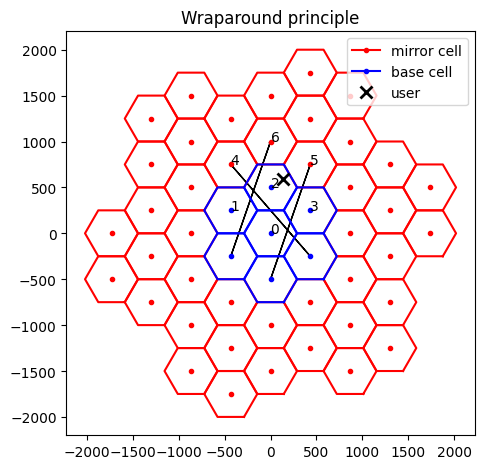

In [7]:
fig = grid.show(show_mirrors=True)
ax = fig.gca()

batch = 0
ut = 30

# Plot mirror cells
ax.plot(*ut_loc[batch, ut, :2], 'xk',
        markersize=8, markeredgewidth=2, label='user')

mirrors_per_ut_loc = flatten_dims(mirrors_per_ut_loc, num_dims=3, axis=1)
mirrors_per_ut_xy_loc = mirrors_per_ut_loc[batch, ut, :, :2]
for cell in range(mirrors_per_ut_xy_loc.shape[0]):
    # Show the cell ID
    ax.text(*mirrors_per_ut_xy_loc[cell, :2], str(cell))

    # Show the translation (if any) from base to mirror cell
    if np.linalg.norm(grid.cell_loc[cell, :2] - mirrors_per_ut_xy_loc[cell, :2]) > .1:
        ax.arrow(*grid.cell_loc[cell, :2],
                 *(mirrors_per_ut_xy_loc[cell, :2] - grid.cell_loc[cell, :2]),
                 head_length=20,
                 head_width=20,
                 length_includes_head=True,
                 fc='black')

ax.set_title('Wraparound principle')
ax.legend()

fig.tight_layout()
plt.show()

In the figure above, the arrows denote the translation (if any) of "base" cells to the artificial,
"mirror" ones.

One can modify the user index `ut` to assess how different user positions
correspond to different wraparound configurations.

## Set up a 3GPP multicell scenario

We can use the function [gen_hexgrid_topology](https://nvlabs.github.io/sionna/sys/api/topology.html#sionna.sys.topology.gen_hexgrid_topology) to place
three base stations at the center of each hexagon, each serving
a sector that covers a 120-degree angle, and drop users across all sectors.  
The inter-site distance, as well as user parameters such as position,
orientation, velocity, and indoor state are set according to a 3GPP-compliant
scenario.


In [8]:
scenario = 'uma'  # 'umi, 'uma', or 'rma'

# Generate the spiral hexagonal grid topology
topology = gen_hexgrid_topology(batch_size=batch_size,
                                num_rings=num_rings,
                                num_ut_per_sector=num_ut_per_sector,
                                min_bs_ut_dist=min_bs_ut_dist,
                                max_bs_ut_dist=max_bs_ut_dist,
                                scenario=scenario,
                                los=True)

ut_loc, bs_loc, ut_orientations, bs_orientations, \
    ut_velocities, in_state, los, bs_virtual_loc = topology

num_bs = bs_loc.shape[1]
num_ut = ut_loc.shape[1]

## Per-stream SINR computation

We next illustrate the functionality enabling the computation of the per-stream,
[post-equalization signal-to-interference-plus-noise ratio (SINR)](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.phy.ofdm.PostEqualizationSINR).

It is assumed that
- Linear precoding is used at the transmitter;
- Linear equalization is used at the receiver;
- The receiver (but not necessarily the transmitter) has perfect knowledge of
  the equalized channel.

The knowledge of the SINR is useful for two main reasons:
- SINR enables the computation of Shannon capacity, for a rapid evaluation of the
  network's performance;
- SINR is used by the PHY abstraction module to bypass physical layer
  computations, as we will see later on.

We will compute the SINR in a multi-cell MIMO scenario with 3GPP-compliant
stochastic channel models and OFDM waveforms.

### Simulation parameters

In [9]:
carrier_frequency = 3.5e9  # [Hz]

# Time/frequency resource grid
# N. OFDM symbols in a slot
num_ofdm_sym = 1
sampling_frequency = 1e-3 / num_ofdm_sym
num_subcarriers = 512
subcarrier_spacing = 30e3  # [Hz]

# Base station and user terminal transmit power
bs_power_dbm = 56  # [dBm]
ut_power_dbm = 13  # [dBm]

direction = 'uplink'  # 'downlink' or 'uplink'

# Environment temperature
temperature = 294  # [K]

# 3GPP scenario parameters
# Outdoor-to-indoor pathloss model
o2i_model = 'low'  # 'low' or 'high'
# Parameters pnly relevant for RMa
average_street_width = 20.
average_building_height = 10.

assert direction in ['uplink', 'downlink']
assert o2i_model in ['low', 'high']

In [10]:
if direction == 'downlink':
    num_rx, num_tx = num_ut, num_bs
else:
    num_rx, num_tx = num_bs, num_ut

# Convert power to W
ut_power = dbm_to_watt(ut_power_dbm)  # [W]
bs_power = dbm_to_watt(bs_power_dbm)  # [W]

# Noise power per subcarrier
no = BOLTZMANN_CONSTANT * temperature * subcarrier_spacing

### Set the antenna patterns

We set the antenna patterns for base stations and user terminals.

Note that the base stations must have a sufficient number of antennas to serve
all connected users simultaneously.

In [11]:
# Create antenna arrays
bs_array = PanelArray(num_rows_per_panel=8,
                      num_cols_per_panel=2,
                      polarization='dual',
                      polarization_type='VH',
                      antenna_pattern='38.901',
                      carrier_frequency=carrier_frequency)

ut_array = PanelArray(num_rows_per_panel=2,
                      num_cols_per_panel=1,
                      polarization='dual',
                      polarization_type='VH',
                      antenna_pattern='omni',
                      carrier_frequency=carrier_frequency)

num_ut_ant = ut_array.num_ant
num_bs_ant = bs_array.num_ant

### Create a 3GPP channel model

Creating a 3GPP-compliant channel model can be done easily via [Sionna PHY's
integrated
models](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#gpp-38-901-channel-models).  
We can choose from Urban Micro-cell (UMi), Urban Macro-cell (UMa), and Rural
Macro-cell (RMa).

In [12]:
# Create channel model
if scenario == 'umi':    # Urban micro-cell
    channel_model = UMi(carrier_frequency=carrier_frequency,
                        o2i_model=o2i_model,
                        ut_array=ut_array,
                        bs_array=bs_array,
                        direction=direction,
                        enable_pathloss=True,
                        enable_shadow_fading=True)
elif scenario == 'uma':  # Urban macro-cell
    channel_model = UMa(carrier_frequency=carrier_frequency,
                        o2i_model=o2i_model,
                        ut_array=ut_array,
                        bs_array=bs_array,
                        direction=direction,
                        enable_pathloss=True,
                        enable_shadow_fading=True)
elif scenario == 'rma':  # Rural macro-cell
    channel_model = RMa(carrier_frequency=carrier_frequency,
                        ut_array=ut_array,
                        bs_array=bs_array,
                        direction=direction,
                        average_street_width=average_street_width,
                        average_building_height=average_building_height,
                        enable_pathloss=True,
                        enable_shadow_fading=True)

We now apply the multicell topology to the specified channel model.

### Generate OFDM channel matrices

After creating the channel model, we will
- Generate the channel impulse response (CIR) for each pair of transmit and
  receive antennas;
- Convert the CIRs to OFDM channel matrices, for each transmitter/receiver pair.

These two steps are handled by the [GenerateOFDMChannel](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.phy.channel.GenerateOFDMChannel) object.

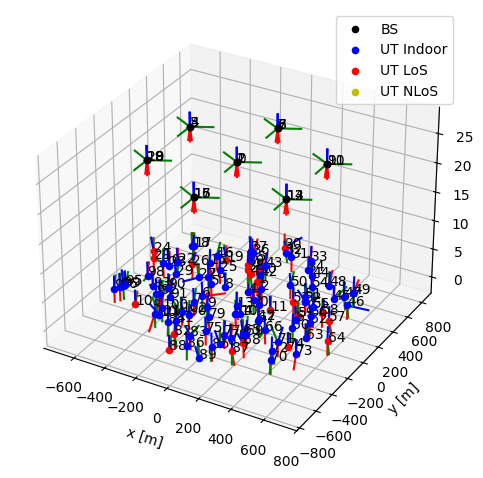

In [13]:
channel_model.set_topology(*topology)
channel_model.show_topology()

In [14]:
# Set n. streams per user = n. antennas
num_streams_per_ut = num_ut_ant

# Set up the OFDM resource grid
resource_grid = ResourceGrid(num_ofdm_symbols=num_ofdm_sym,
                             fft_size=num_subcarriers,
                             subcarrier_spacing=subcarrier_spacing,
                             num_tx=num_ut_per_sector,
                             num_streams_per_tx=num_streams_per_ut)

# Instantiate the OFDM channel generator
ofdm_channel = GenerateOFDMChannel(channel_model, resource_grid)

# Generate the OFDM channel matrix
# [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
h_freq = ofdm_channel(batch_size)

assert num_streams_per_ut <= num_ut_ant, \
    "The # of streams per user must not exceed the # of its antennas"

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [ ]:
h_freq_reordered = tf.transpose(
    h_freq,
    perm=[0, 1, 3, 5, 6, 4, 2]
)
print(h_freq_reordered.shape,h_freq.shape)
import numpy as np
import matplotlib.pyplot as plt

# ---- user selection ----
bs_idx = 0          # select base station index
rx_idx = 0          # select receiver index
batch_idx = 0       # pick one batch example (or average across batch; see below)
sym_idx = 0         # the "1" dimension (e.g., num_ofdm_symbols=1)

# ---- extract frequency response for the chosen BS/RX ----
# h_sel: [NFFT, n_tx_ant, n_rx_ant]
h_sel = h_freq_reordered[batch_idx, bs_idx, rx_idx, sym_idx, :, :, :]

# If your subcarriers are centered around DC (i.e., FFT-shifted),
# uncomment the next line before IFFT:
# h_sel = np.fft.ifftshift(h_sel, axes=0)

# ---- IFFT to time domain (impulse response), along the NFFT axis ----
# h_time: [NFFT, n_tx_ant, n_rx_ant]
h_time = np.fft.ifft(h_sel, axis=0)

# ---- plot impulse responses for all Tx/Rx antenna pairs ----
NFFT = h_time.shape[0]
n_tx_ant = h_time.shape[1]
n_rx_ant = h_time.shape[2]
taps = np.arange(NFFT)

plt.figure()
for txa in range(n_tx_ant):
    for rxa in range(n_rx_ant):
        cir = h_time[:, txa, rxa]
        plt.plot(taps, np.abs(cir), label=f"TxAnt {txa} -> RxAnt {rxa}")

plt.title(f"Channel Impulse Response | BS={bs_idx}, RX={rx_idx}, batch={batch_idx}")
plt.xlabel("Tap index (n)")
plt.ylabel("|h[n]|")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Ensure tensor is on CPU and detached
h_freq_np = h_freq_reordered.detach().cpu().numpy()
np.save("h_freq.npy", h_freq_np)
h_freq_np = np.load("h_freq.npy")
print(h_freq_np.shape)

### Stream management

We now associate each receiver to the corresponding serving transmitter, via a
[StreamManagement](https://nvlabs.github.io/sionna/phy/api/mimo.html#stream-management) object.

In [ ]:
# For simplicity, each user is served by its closest base station
if direction == 'downlink':
    num_streams_per_tx = num_streams_per_ut * num_ut_per_sector
    # RX-TX association matrix
    rx_tx_association = np.zeros([num_rx, num_tx])
    idx = np.array([[i1, i2] for i2 in range(num_tx) for i1 in
                    np.arange(i2*num_ut_per_sector, (i2+1)*num_ut_per_sector)])
    rx_tx_association[idx[:, 0], idx[:, 1]] = 1
else:
    num_streams_per_tx = num_streams_per_ut
    # RX-TX association matrix
    rx_tx_association = np.zeros([num_rx, num_tx])
    idx = np.array([[i1, i2] for i1 in range(num_rx) for i2 in
                    np.arange(i1*num_ut_per_sector, (i1+1)*num_ut_per_sector)])
    rx_tx_association[idx[:, 0], idx[:, 1]] = 1

# Instantiate a Stream Management object
stream_management = StreamManagement(rx_tx_association, num_streams_per_tx)

### Compute SINR

We are finally ready to compute the post-equalization SINR on a per-stream basis.

Note that the transmitter must allocate powers across streams, a task handled by
the scheduler and power control.  
Since these modules are not the focus of this notebook, we assume a
simplified model with uniform power allocation  across randomly selected
streams.

In [ ]:
# User streams are allocated randomly across subcarriers
# Uniform power allocation
# [batch_size, num_ofdm_sym, num_subcarriers, num_tx, num_streams_per_tx]
is_scheduled = sample_bernoulli([batch_size,
                                 num_ofdm_sym,
                                 num_subcarriers,
                                 num_ut,
                                 num_streams_per_ut],
                                p=.3)

tx_power_per_ut = ut_power if direction == 'uplink' else bs_power / num_ut_per_sector
tx_power_per_ut = tf.fill([batch_size, num_ofdm_sym, num_ut], tx_power_per_ut)

# [batch_size, num_tx, num_streams_per_tx, num_ofdm_sym, num_subcarriers]
tx_power = spread_across_subcarriers(tx_power_per_ut,
                                     is_scheduled,
                                     num_tx=num_tx)

if direction == 'downlink':
    precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management)
    h_eff = precoded_channel(h_freq, tx_power=tx_power, alpha=no)
else:
    # No precoding in the uplink
    precoded_channel = EyePrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management)
    h_eff = precoded_channel(h_freq, tx_power=tx_power)

lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                              stream_management=stream_management)

# [batch_size, num_ofdm_symbols, num_subcarriers, num_rx, num_streams_per_rx]
sinr = lmmse_posteq_sinr(h_eff, no=no, interference_whitening=True)
# [batch_size, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
sinr = tf.reshape(sinr,
                  sinr.shape[:-2] + [num_bs*num_ut_per_sector, num_streams_per_ut])
print(f'{sinr.shape = }')

It is immediate to compute the associated Shannon capacity.

In [ ]:
# Compute maximum achievable spectral efficiency (SE) per resource element
# [batch_size, num_ofdm_sym, num_subcarriers, num_ut]
se_shannon = tf.reduce_sum(log2(1 + sinr), axis=-1)

# Average across resource elements for each user
# [batch_size, num_ut]
se_shannon = tf.reduce_mean(se_shannon, axis=[-2, -3])

We now visualize the produced SINR and the spectral efficiency distribution across users.

In [2]:
def get_cdf(values):
    """
    Computes the Cumulative Distribution Function (CDF) of the input vector
    """
    values = np.array(values).flatten()
    n = len(values)
    sorted_val = np.sort(values)
    cumulative_prob = np.arange(1, n+1) / n
    return sorted_val, cumulative_prob

# Plot SINR
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

ax[0].plot(*get_cdf(10*np.log10(sinr[sinr > 0])))
ax[0].set_xlabel('SINR [dB]')
ax[0].set_ylabel('Cumulative density function')
ax[0].set_title('SINR across Users and Resource Elements')
ax[0].grid()

# Plot SE
ax[1].plot(*get_cdf(se_shannon))
ax[1].grid()
ax[1].set_title('Shannon spectral efficiency ')
ax[1].set_ylabel('Cumulative density function')
ax[1].set_xlabel('Spectral Efficiency [bps/Hz]')
fig.tight_layout()

plt.show()

NameError: name 'plt' is not defined

### Differentiability

We finally show that the per-user Shannon capacity is differentiable with
respect to the transmit power.  
In fact, this holds for any differentiable function of the SINR.

In [ ]:
# Transmit power value at which the gradient is computed
tx_power_re = tf.Variable(tf.ones([batch_size, num_tx, num_streams_per_tx, num_ofdm_sym, num_subcarriers]))

with tf.GradientTape() as tape:
    if direction == 'downlink':
        precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                              stream_management=stream_management)
        h_eff = precoded_channel(h_freq, tx_power=tx_power_re, alpha=no)
    else:
        precoded_channel = EyePrecodedChannel(resource_grid=resource_grid,
                                              stream_management=stream_management)
        h_eff = precoded_channel(h_freq, tx_power=tx_power_re)

    lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                  stream_management=stream_management)

    # [batch_size, num_ofdm_symbols, num_effective_subcarriers, num_rx, num_streams_per_rx]
    sinr = lmmse_posteq_sinr(h_eff, no=no, interference_whitening=True)

    # Per-stream Shannon capacity
    capacity_re = log2(1 + sinr)

    # Average capacity across users and resources
    capacity_re_avg = tf.reduce_mean(capacity_re)

print(f'{tx_power_re.shape = }')
# [num_tx, num_streams_per_tx]

# Compute Gradient d(capacity_re_avg)/d(tx_power_i), for all i
d_capacity_d_tx_power = tape.gradient(capacity_re_avg, tx_power_re).numpy()

print(f'{d_capacity_d_tx_power.shape = }')
# [num_tx, num_streams_per_tx, num_ut]

## Conclusions

The [gen_hexgrid_topology](https://nvlabs.github.io/sionna/sys/api/topology.html#sionna.sys.topology.gen_hexgrid_topology) function enables the creation of a 3GPP-compliant
multicell scenario with hexagonal cells arranged on a spiral grid.  
To eliminate
border effects at the network edge, the wraparound technique is
applied by assigning each user a set of "mirror" base station position.

Once users are placed in the network, the SINR
and the associated Shannon capacity can be computed, providing an upper bound
for the achievable spectral efficiency.  

Evaluating the *actual* spectral efficiency would ideally require
simulating the entire physical layer (PHY) chain, including
modulation, coding, demodulation, and decoding.

As a computationally cheaper alternative, one can bypass the PHY chain
via the [PHYAbstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html) functionality, as shown in the
[physical layer abstraction notebook](https://nvlabs.github.io/sionna/sys/tutorials/PHY_Abstraction.html).